In [1]:
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import tensorflow as tf
import numpy as np
import gymnasium as gym
import keras
import matplotlib.pyplot as plt

In this notebook i'll try to solve OpenAI's Lunar Lander environment using a custom made DDQN model.

In [2]:
class Transition:
    def __init__(self, state, action, reward, next_state, terminated):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.terminated = terminated
        
        self.data = [self.state, self.action, self.reward, self.next_state, self.terminated]
        
    def __repr__(self):
        return f"Transition{self.data}"
    
    def __iter__(self):
        return iter(self.data)
    
    def __getitem__(self, item):
         return self.data[item]

In [3]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def store(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return batch

In [9]:
class Agent:
    def __init__(self, policy, memory, batch_size, update_frequency, env, tau, gamma):

        self.policy = policy
        self.memory = memory
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.env = env
        self.tau = tau
        self.gamma = gamma
        self.rewards = []


    def select_action(self, state):
        return self.policy.select_action(state)
        
    def train(self, batch_size):
        
        # making sure the program doesn't crash when there aren't any memories
        if batch_size > len(self.memory.memory):
            return
        
        batch = self.memory.sample(batch_size)
                        
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        # using numpy matrix indexing instead of while loops
        targets = self.policy.model.predict(states, verbose = 0)
        next_actions = np.argmax(self.policy.model.predict(next_states, verbose = 0), axis=1)
        next_q_values = self.policy.target_model.predict(next_states, verbose = 0)
        
        targets[np.arange(len(batch)), actions] = rewards + self.gamma * next_q_values[np.arange(len(batch)), next_actions] * (1 - dones)
        
        self.policy.model.train_on_batch(states, targets)

    
    def decay(self):
        self.policy.epsilon = max(self.policy.min_epsilon, self.policy.epsilon * self.policy.epsilon_decay_rate)

        
    def align_target_network(self):
        model_weights = self.policy.model.get_weights()
        target_model_weights = self.policy.target_model.get_weights()
        for i in range(len(target_model_weights)):
            target_model_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_model_weights[i]
        self.policy.target_model.set_weights(target_model_weights)
        
    def save_model(self, path):
        self.policy.model.save(path)

        
    def load_model(self, path):
        new_model = keras.models.load_model(path)
        new_model_weights = new_model.get_weights()
        self.policy.model.set_weights(new_model_weights)
        self.policy.target_model.set_weights(new_model_weights)
    
    def plot(self,window_size, rewards):
        
        averages = [np.mean(rewards[i:i+window_size]) for i in range(0, len(rewards), window_size)]

        plt.plot([i * window_size for i in range(len(averages))], averages)
        plt.scatter([i for i in range(len(rewards))], rewards)
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.show()

    def run(self, train = False, verbose = True, n_episodes = 1000):
        
        steps = 0
        for episode in range(n_episodes):
            ep_rewards = []
            state, info = self.env.reset()
            while True:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                ep_rewards.append(reward)
                
                if train:
                    self.memory.store(Transition(state, action, reward, next_state, terminated))
                state = next_state
                
                if steps % self.update_frequency == 0 and train:
                    self.train(self.batch_size)
                    self.align_target_network()
                steps += 1

                if terminated or truncated:
                    break
                    
                                    
            self.rewards.append(sum(ep_rewards))
            self.decay()
            
            
            if verbose:
                print(f"\repisode: {episode} | reward: {sum(ep_rewards)}", end = "")
                if (episode +1) % 100 == 0:
                    self.plot(window_size = 10, rewards = self.rewards)
                



In [10]:
class EpsilonGreedyPolicy:
    
    def __init__(self,epsilon, epsilon_decay_rate, state_size, action_size, alpha, min_epsilon):
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.alpha = alpha
        self.state_size = state_size
        self.action_size = action_size
        self.min_epsilon = min_epsilon
        
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def select_action(self, state):
        if random.random() < self.epsilon:
            action = random.randint(0, self.action_size - 1)
        else:
            reshaped_state = state.reshape(1, -1)
            action = np.argmax(self.model.predict(reshaped_state, verbose = 0)[0])
        return action
    
    def build_model(self):
        
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber', optimizer=Adam(learning_rate=self.alpha))
    
        return model

In [11]:
env = gym.make("LunarLander-v2", render_mode="human")

In [12]:
DDQN = Agent(policy = EpsilonGreedyPolicy(alpha = 0.0005, epsilon = 0.16, epsilon_decay_rate = 0.996, min_epsilon = 0.01, state_size = 8, action_size = 4),
             tau = 0.01, gamma = 0.99,memory = Memory(capacity = 100000), batch_size = 64, update_frequency = 2, env = env)

In [8]:
DDQN.run(train = True, verbose = 1, n_episodes = 700)


KeyboardInterrupt



In [17]:
DDQN.load_model("model_3")

In [18]:
DDQN.policy.epsilon = 0

In [19]:
env = gym.make("LunarLander-v2", render_mode="human")
DDQN.env = env

episode: 99 | reward: 212.41913952950893 | epsilon 0.01

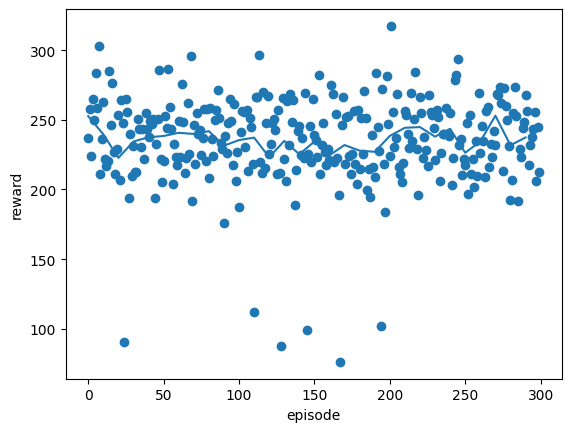

episode: 199 | reward: 251.18059422087603 | epsilon 0.01

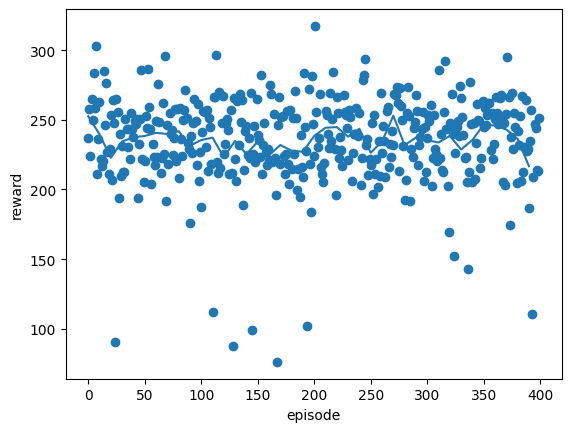

In [20]:
DDQN.run(train = False, verbose = True, n_episodes = 200)

The game is considered solved at a mean reward of 200

In [21]:
np.mean(DDQN.rewards)

235.81119844390304